# Using `xarray` to parse the data

In [2]:
%load_ext autoreload
%autoreload 2

In [58]:
import rasterio
import rioxarray
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

from src.dnbr import apply_bit_mask_group, apply_bitmask

In [6]:
# Get list of files
sherlock_path = "/mnt/sherlock/oak/prescribed_data/raw/landsat-c2-l2-post-buf/"
paths_to_post = list(Path(sherlock_path).rglob("*.nc4"))

### Open the dataset

In [9]:
ds = (
    xr.open_dataset(paths_to_post[120])
    .to_array() # transform to an array rather than the xr.Dataset
    .squeeze()  # just like in numpy, remove all singletons
)
ds

<xarray.DataArray (time: 4, band: 6, y: 205, x: 225)>
array([[[[ 8099.,  8018.,  8006., ...,  8005.,  7916.,  7938.],
         [ 8315.,  8103.,  7975., ...,  7935.,  7897.,  7874.],
         [ 8261.,  8160.,  8100., ...,  7885.,  7876.,  7872.],
         ...,
         [ 8031.,  8003.,  8093., ...,  8187.,  8157.,  8267.],
         [ 8092.,  8024.,  8072., ...,  8194.,  8251.,  8394.],
         [ 8187.,  8223.,  8328., ...,  8208.,  8312.,  8499.]],

        [[ 8634.,  8614.,  8639., ...,  8521.,  8574.,  8531.],
         [ 8881.,  8652.,  8512., ...,  8401.,  8443.,  8423.],
         [ 8851.,  8795.,  8655., ...,  8430.,  8383.,  8383.],
         ...,
         [ 8609.,  8779.,  8662., ...,  8808.,  8682.,  8899.],
         [ 8747.,  8779.,  8732., ...,  8878.,  8955.,  9203.],
         [ 8855.,  9014.,  8994., ...,  8879.,  9033.,  9292.]],

        [[ 8552.,  8481.,  8470., ...,  8384.,  8363.,  8432.],
         [ 8869.,  8625.,  8422., ...,  8324.,  8344.,  8271.],
         [ 8780.,  8751.,  8643., ...,  8352.,  8268.,  8184.],
         ...,
...
         ...,
         [17258., 18222., 17808., ..., 14565., 13591., 14841.],
         [18056., 18071., 17932., ..., 14936., 13705., 14940.],
         [18631., 17858., 17585., ..., 14770., 14497., 15380.]],

        [[10600., 10313., 10123., ...,  9681.,  9670.,  9569.],
         [11606., 10800.,  9989., ...,  9357.,  9365.,  9148.],
         [11261., 11057., 10602., ...,  9120.,  9046.,  8849.],
         ...,
         [11383., 11410., 11206., ..., 10083.,  9846., 10811.],
         [12134., 11631., 11546., ...,  9851.,  9965., 11130.],
         [12676., 12220., 12289., ..., 10038., 10441., 11235.]],

        [[ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         ...,
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.]]]])
Coordinates: (12/17)
  * time                      (time) datetime64[ns] 2000-07-17T18:22:19.37408...
    id                        (time) object ...
  * band                      (band) object 'blue' 'green' ... 'qa_pixel'
  * x                         (x) float64 -121.1 -121.1 -121.1 ... -121.0 -121.0
  * y                         (y) float64 39.86 39.86 39.86 ... 39.81 39.81
    platform                  object ...
    ...                        ...
    landsat:scene_id          (time) object ...
    title                     (band) object ...
    common_name               (band) object ...
    full_width_half_max       (band) float64 ...
    epsg                      int64 ...
    variable                  <U42 'stackstac-acec556a5c1edd76274007ae9be72ec8'

### Slicing and selecting data

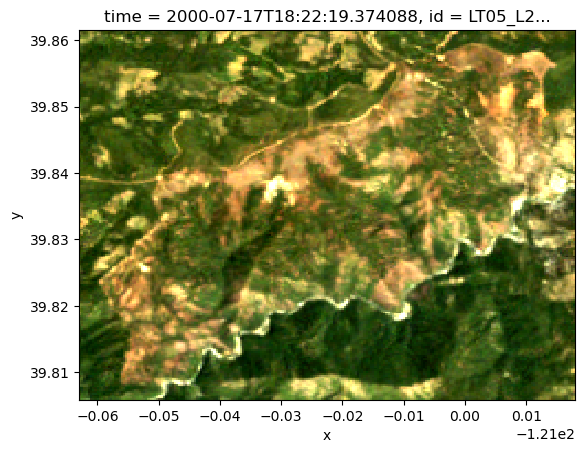

In [10]:
ds.sel(band=["red", "green", "blue"]).isel(time=0).plot.imshow(robust=True)

### You can also aggregate across the time dimension and get a composite

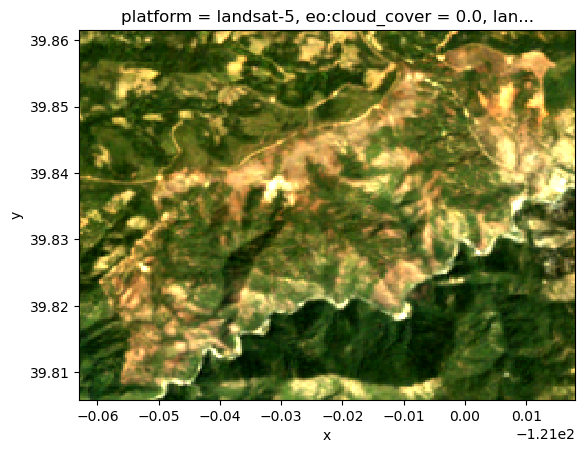

In [11]:
ds.median(dim="time").sel(band=["red", "green", "blue"]).plot.imshow(robust=True)

Often with composites, we want to solve issues like cloud coverage or bad pixels, but is good to do some QA cleaning per each satellite type. 

In [12]:
ds_clean = apply_bit_mask_group(ds).compute()

Exception: len() of unsized object. Maybe platform length is zero: landsat-5


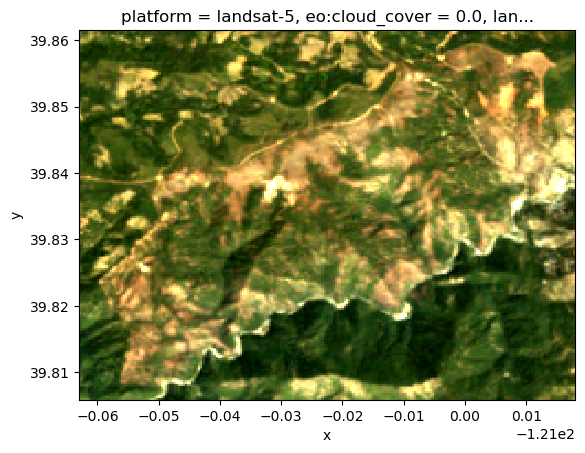

In [13]:
ds_clean.compute().median(dim="time").sel(band=["red", "green", "blue"]).plot.imshow(robust=True)

## Exploring geographical data in Python

Spatial data can be stored in many different ways! Most vector data (i.e. shapes, lines, etc.) are stored in Shapefiles (`.shp`). The easiest and more pythonic way to deal with this data is by using `geopandas`. Just like `pandas`, you have the data in a `DataFrame` and you can do the same methods and functions. 


In [42]:
# Open the MTBS data, this is the same data you get from the MTBS webpage
mtbs = gpd.read_file("/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD/")
wildfires_ca = mtbs[(mtbs.Event_ID.str.contains("CA") & (mtbs.Incid_Type == "Wildfire"))]
wildfires_ca.head(10)

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,CA3370911761819840126,NaN,MODJESKA,Wildfire,10005362,MTBS,Extended (SS),1266,33.708,-117.639,...,504003719840323,-9999,-9999,9999,9999,150,-70,-170,NaN,"MULTIPOLYGON (((-117.64264 33.70811, -117.6424..."
3,CA3607412018819840329,NaN,FK 1817,Wildfire,4557,MTBS,Initial (SS),1462,36.074,-120.188,...,NaN,-9999,-9999,9999,9999,-65,-280,-9999,Single scene assessment,"POLYGON ((-120.18164 36.05393, -120.18211 36.0..."
7,CA3268211688619840421,NaN,PROCTOR,Wildfire,4637,MTBS,Initial,3021,32.682,-116.886,...,NaN,38,-9999,-970,-150,130,359,630,NaN,"POLYGON ((-116.89745 32.69498, -116.89574 32.6..."
12,CA3480712050119840507,NaN,MINUTEMAN,Wildfire,4630,MTBS,Initial (SS),3159,34.807,-120.501,...,NaN,-9999,-9999,9999,9999,-25,-265,-9999,Single scene assessment,"POLYGON ((-120.47030 34.79960, -120.47065 34.7..."
13,CA3433111896419840507,NaN,GRIMES FIRE,Wildfire,4645,MTBS,Initial (SS),10917,34.331,-118.964,...,NaN,-9999,-9999,9999,9999,20,-300,-9999,Single scene assessment,"POLYGON ((-118.99636 34.34969, -118.99589 34.3..."
14,CA3470111707519840512,NaN,STODDARD 2,Wildfire,4565,MTBS,Initial (SS),2458,34.701,-117.075,...,NaN,-9999,-9999,9999,9999,-50,-190,-9999,NaN,"POLYGON ((-117.06736 34.70991, -117.06670 34.7..."
18,CA3709812116219840521,NaN,COTTONWOOD,Wildfire,4636,MTBS,Initial (SS),1409,37.098,-121.162,...,NaN,-9999,-9999,9999,9999,40,-275,-9999,NaN,"POLYGON ((-121.17551 37.10310, -121.17165 37.1..."
20,CA3589912013419840525,NaN,FLAT TOP,Wildfire,4632,MTBS,Initial (SS),6693,35.899,-120.134,...,NaN,-9999,-9999,9999,9999,-65,-9999,-9999,Single scene assessment,"POLYGON ((-120.13213 35.85674, -120.13275 35.8..."
21,CA3626012031719840525,NaN,OIL FIELDS,Wildfire,4633,MTBS,Initial (SS),1136,36.260,-120.317,...,NaN,-9999,-9999,9999,9999,-50,-212,-9999,NaN,"POLYGON ((-120.31646 36.23937, -120.31752 36.2..."
22,CA3561111844619840526,NaN,WOODROW,Wildfire,4558,MTBS,Initial (SS),1118,35.611,-118.446,...,NaN,-9999,-9999,9999,9999,-25,-145,-225,NaN,"POLYGON ((-118.43784 35.60767, -118.43830 35.6..."


We need to project our spatial data (MTBS) to align to the same projection space as our remote-sense data. To do this, we are going to use the Mercator projection (WGS84), which has the EPSG code `4326`. If all this sounds weird, please read [this](https://geohackweek.github.io/visualization/02-projections/) and learn more about projections and why we care about them. 

In Linear Algebra terms, we are doing an affine transform to a grid, so that's all projecting is doing! 

In [43]:
wildfires_ca = wildfires_ca.to_crs("EPSG:4326")

Notice that the `Event_ID` column corresponds to the file names we have in the bucket. If you want more info on the fire we are looking, just do:

(Notice the tricks the `Path` class has `:-)` )

In [51]:
wildfires_ca[wildfires_ca.Event_ID == paths_to_post[120].stem].iloc[0]

Event_ID                                  CA3983412102119990823
irwinID                                                     NaN
Incid_Name                                MHRD COMPLEX (PIGEON)
Incid_Type                                             Wildfire
Map_ID                                                    10703
Map_Prog                                                   MTBS
Asmnt_Type                                             Extended
BurnBndAc                                                  4810
BurnBndLat                                               39.834
BurnBndLon                                             -121.021
Ig_Date                                              1999-08-23
Pre_ID                                          504403219990816
Post_ID                                         504403220000802
Perim_ID                                                    NaN
dNBR_offst                                                   16
dNBR_stdDv                              

### Masking and extracting data

One of the things you can do with the array data is to clip and extract data to your desire extent. A helpful library for this is `rioxarray`, which combines the powers of `rasterio` (the default raster library in Python) with `xarray` (the default multi-dimensional data library in Python).

In [66]:
ds = (
    xr.open_dataset(paths_to_post[120])
    .to_array() # transform to an array rather than the xr.Dataset
    .squeeze()  # just like in numpy, remove all singletons
)
ds.rio.set_crs(4326)
ds

<xarray.DataArray (time: 4, band: 6, y: 205, x: 225)>
array([[[[ 8099.,  8018.,  8006., ...,  8005.,  7916.,  7938.],
         [ 8315.,  8103.,  7975., ...,  7935.,  7897.,  7874.],
         [ 8261.,  8160.,  8100., ...,  7885.,  7876.,  7872.],
         ...,
         [ 8031.,  8003.,  8093., ...,  8187.,  8157.,  8267.],
         [ 8092.,  8024.,  8072., ...,  8194.,  8251.,  8394.],
         [ 8187.,  8223.,  8328., ...,  8208.,  8312.,  8499.]],

        [[ 8634.,  8614.,  8639., ...,  8521.,  8574.,  8531.],
         [ 8881.,  8652.,  8512., ...,  8401.,  8443.,  8423.],
         [ 8851.,  8795.,  8655., ...,  8430.,  8383.,  8383.],
         ...,
         [ 8609.,  8779.,  8662., ...,  8808.,  8682.,  8899.],
         [ 8747.,  8779.,  8732., ...,  8878.,  8955.,  9203.],
         [ 8855.,  9014.,  8994., ...,  8879.,  9033.,  9292.]],

        [[ 8552.,  8481.,  8470., ...,  8384.,  8363.,  8432.],
         [ 8869.,  8625.,  8422., ...,  8324.,  8344.,  8271.],
         [ 8780.,  8751.,  8643., ...,  8352.,  8268.,  8184.],
         ...,
...
         ...,
         [17258., 18222., 17808., ..., 14565., 13591., 14841.],
         [18056., 18071., 17932., ..., 14936., 13705., 14940.],
         [18631., 17858., 17585., ..., 14770., 14497., 15380.]],

        [[10600., 10313., 10123., ...,  9681.,  9670.,  9569.],
         [11606., 10800.,  9989., ...,  9357.,  9365.,  9148.],
         [11261., 11057., 10602., ...,  9120.,  9046.,  8849.],
         ...,
         [11383., 11410., 11206., ..., 10083.,  9846., 10811.],
         [12134., 11631., 11546., ...,  9851.,  9965., 11130.],
         [12676., 12220., 12289., ..., 10038., 10441., 11235.]],

        [[ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         ...,
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.]]]])
Coordinates: (12/17)
  * time                      (time) datetime64[ns] 2000-07-17T18:22:19.37408...
    id                        (time) object ...
  * band                      (band) object 'blue' 'green' ... 'qa_pixel'
  * x                         (x) float64 -121.1 -121.1 -121.1 ... -121.0 -121.0
  * y                         (y) float64 39.86 39.86 39.86 ... 39.81 39.81
    platform                  object ...
    ...                        ...
    landsat:scene_id          (time) object ...
    title                     (band) object ...
    common_name               (band) object ...
    full_width_half_max       (band) float64 ...
    epsg                      int64 ...
    variable                  <U42 'stackstac-acec556a5c1edd76274007ae9be72ec8'

<Axes: title={'center': 'platform = landsat-5, eo:cloud_cover = 0.0, lan...'}, xlabel='x', ylabel='y'>

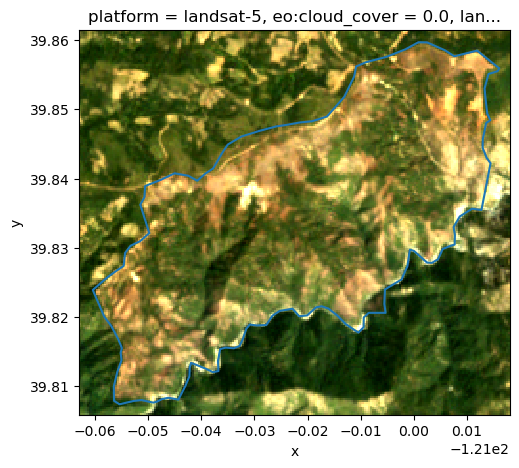

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))
ds.median(dim="time").sel(band=["red", "green", "blue"]).plot.imshow(robust=True, ax=ax)

# Plot the boundary of the polygon, not the whole polygon
wildfires_ca[wildfires_ca.Event_ID == paths_to_post[120].stem].geometry.boundary.plot(ax=ax)

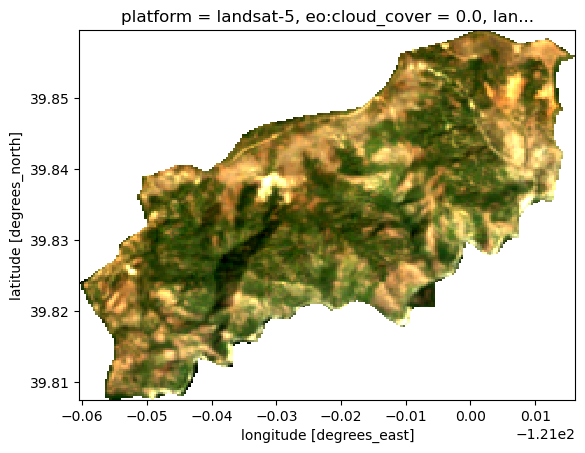

In [72]:
clipped = ds.rio.clip(wildfires_ca[wildfires_ca.Event_ID == paths_to_post[120].stem].geometry)
clipped.median(dim="time").sel(band=["red", "green", "blue"]).plot.imshow(robust=True)